In [1]:
# ei_selection.ipynb
# This notebook is used to create a balanced network of excitatory and inhibitory units that become selective
# for particular input patterns. It has the same network as ei_selective.ipynb, but in here most things are 
# encapsulated within the selection class.

# By Sergio Verduzco Flores        August 2017

from draculab import *
from matplotlib import pyplot as plt
import numpy as np
import time
from mpl_toolkits.axes_grid1 import ImageGrid

The cells below:
* Create two NxN layers, one excitatory, and one inhibitory.
* Connect the layers with center-excitation surround-inhibition connectivity. E-E connections use
  Hebbian learning with substractive normalization, I-E connections use homeostatic inhibition,
  similar to Moldakarimov06 (in ei_net.ipynb).
* Create an input layer where the activity of each unit is a function of the current input pattern.
* Connects the input layer to E,I layers using a connection pattern based on a Gaussian kernel, and
  using BCM synapses.
* Runs a simulation where input patterns are randomly selected and presented sequentially, similarly
  to the way this was done in the test3,4,5 notebooks.
  
The experiment consists of finding whether selectivity to patterns will arise in the units.
- - -


In [2]:
class selection():
    def __init__(self):
        ########################## Here be all parameters
        # NETWORK PARAMETERS
        md = 0.1 # minimum delay in the network
        min_buff_size = 3 # minimum buffer size
        rtol = 1e-4 # relative tolerance of the ODE solver
        atol = 1e-4 # absolute tolerance of the ODE solver
        N = 5 # The network's layers will have size NxN
        L = (N/2.) + 2./N # side length of the square unit grids
        self.N = N
        
        # EXCITATORY UNIT PARAMETERS
        exc_tau = np.random.uniform(2., 3.5, N*N)   # time constants
        exc_init_val = np.random.uniform(0., 0.6, N*N)  # initial activations
        exc_tau_fast = 0.2  # time constant of the fast low-pass filter
        exc_tau_slow = 20.  # time constant of the slow low-pass filter (for BCM)
        fe_thr = 0.3 # threshold of the f-I curve
        fe_eps = 0.2 # epsilon parameter of the f-I curve
        # geometrical arrangement of the excitatory units
        exc_shape = 'sheet'
        exc_extent = [L, L]
        exc_arrangement = 'grid'
        exc_rows = N
        exc_columns = N
        exc_center = [0., 0.]
        
        # INHIBITORY UNIT PARAMETERS
        inh_tau = np.random.uniform(2.5, 4., N*N)   # time constants
        inh_init_val = np.random.uniform(0., 0.6, N*N)  # initial activations
        inh_tau_fast = 0.2  # time constant of the fast low-pass filter
        inh_tau_slow = 20.  # time constant of the slow low-pass filter (for BCM)
        fi_thr = 0.4 # threshold of the f-I curve
        fi_eps = 0.2 # epsilon parameter of the f-I curve
        # geometrical arrangement of the inhibitory units
        inh_shape = 'sheet'
        inh_extent = [L, L]
        inh_arrangement = 'grid'
        inh_rows = N
        inh_columns = N
        inh_center = [0., 0.]
        
        # INPUT UNIT PARAMETERS
        inp_init_val = 0. # initial activation
        inp_tau_fast = 0.2 # time constant of the fast low-pass filter
        # geometrical arrangement of the input units
        inp_shape = 'sheet'
        inp_extent = [L, L]
        inp_arrangement = 'grid'
        inp_rows = N
        inp_columns = N
        inp_center = [0., 0.]
        
        # E-I CONNECTIONS
        EI_connection_type = 'convergent'
        EI_mask = {'annular':{'inner_radius' : 1.1, 'outer_radius':4.1}}
        EI_kernel = {'linear' : {'c' : 1., 'a' : 0.2}}
        EI_delays = {'linear' : {'c' : md, 'a' : 0.3}}
        EI_weights = {'uniform' : {'low' : 0.5, 'high' : 0.8}}
        EI_edge_wrap = True
        EI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        EI_type = synapse_types.static
        
        # E-E CONNECTIONS
        EE_connection_type = 'divergent'
        EE_mask = {'circular':{'radius':2.}}
        EE_kernel = {'gaussian' : {'p_center' : 1., 'sigma' : 1.}}
        EE_delays = {'linear' : {'c' : md, 'a' : 0.3}}
        EE_weights =  {'uniform' : {'low' : 0.1, 'high' : 0.6}}
        EE_edge_wrap = True
        EE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        EE_type = synapse_types.sq_hebbsnorm 
        EE_lrate = 1./200. # learning rate
        EE_omega = 2.5  # sum of squared EE weights 
        
        # I-E CONNECTIONS
        IE_connection_type = 'divergent'
        IE_mask = {'circular':{'radius':2.}}
        IE_kernel = {'gaussian' : {'p_center' : 1.4, 'sigma' : 1.}}
        IE_delays = {'linear' : {'c' : md, 'a' : 0.3}}
        IE_weights =  {'uniform' : {'low' : -0.6, 'high' : -0.1}}
        IE_edge_wrap = True
        IE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        IE_type = synapse_types.homeo_inh
        IE_lrate = 1./100. 
        IE_des_act = 0.3
        
        # INP_EXC CONNECTIONS
        PE_connection_type = 'divergent'
        PE_mask = {'circular':{'radius':3.5}}
        PE_kernel = 0.6
        PE_delays = {'linear' : {'c' : md, 'a' : 0.3}}
        PE_weights = {'uniform' : {'low' : 0.3, 'high' : 0.5}}
        PE_edge_wrap = True
        PE_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        PE_type = synapse_types.bcm
        PE_lrate = 1./200.
        
        # INP_INH CONNECTIONS
        PI_connection_type = 'divergent'
        PI_mask = {'circular':{'radius':3.5}}
        PI_kernel = 0.6
        PI_delays = {'linear' : {'c' : md, 'a' : 0.3}}
        PI_weights = {'uniform' : {'low' : 0.3, 'high' : 0.5}}
        PI_edge_wrap = True
        PI_boundary = {'center' : [0.,0.], 'extent' : [L, L]}
        PI_type = synapse_types.bcm
        PI_lrate = 1./200.
        
        # PATTERN PRESENTATION
        self.t_pat = 20. # time each pattern will be presented
        self.t_trans = 5. # length of transition period between patterns
        self.c = 1./self.t_trans # auxiliary variable for make_fun2
             
        ########################## Initialize all the parameter dictionaries 
        self.net_params = {'min_delay' : md, 
                           'min_buff_size' : min_buff_size, 
                           'rtol':rtol, 
                           'atol':atol } 
        self.exc_params = {'tau' : exc_tau,
                           'function' : self.make_fe(fe_thr, fe_eps), 
                           'type' : unit_types.custom_fi, 
                           'init_val' : exc_init_val, 
                           'tau_fast' : exc_tau_fast, 
                           'tau_slow' : exc_tau_slow } # tau_slow vs lrate controls stability of BCM
        self.exc_geom = {'shape' : exc_shape, 
                         'extent' : exc_extent, 
                         'arrangement' : exc_arrangement, 
                         'rows' : exc_rows, 
                         'columns' : exc_columns, 
                         'center' : exc_center }
        self.inh_params = {'tau' :inh_tau, 
                           'function' : self.make_fi(fi_thr, fi_eps), 
                           'type' : unit_types.custom_fi, 
                           'init_val' : inh_init_val, 
                           'tau_fast' : inh_tau_fast, 
                           'tau_slow' : inh_tau_slow }
        self.inh_geom = {'shape' : inh_shape, 
                         'extent' : inh_extent, 
                         'arrangement' : inh_arrangement, 
                         'rows' : inh_rows, 
                         'columns' : inh_columns, 
                         'center' : inh_center }
        self.inp_params = {'type' : unit_types.source, 
                           'init_val' : inp_init_val, 
                           'tau_fast' : inp_tau_fast, 
                           'function' : lambda x: None }
        self.inp_geom = {'shape' : inp_shape, 
                         'extent' : inp_extent, 
                         'arrangement' : inp_arrangement, 
                         'rows' : inp_rows, 
                         'columns' : inp_columns, 
                         'center' : inp_center }
        self.EI_conn = {'connection_type' : EI_connection_type,
                        'mask' : EI_mask,
                        'kernel' : EI_kernel,
                        'delays' : EI_delays,
                        'weights' : EI_weights,
                        'edge_wrap' : EI_edge_wrap,
                        'boundary' : EI_boundary }
        self.EI_syn = {'type' : EI_type }
        self.EE_conn = {'connection_type' : EE_connection_type,
                        'mask' : EE_mask,
                        'kernel' : EE_kernel,
                        'delays' : EE_delays,
                        'weights' : EE_weights,
                        'edge_wrap' : EE_edge_wrap,
                        'boundary' : EE_boundary }
        self.EE_syn = {'type' : EE_type, 
                       'lrate' : EE_lrate, 
                       'omega' : EE_omega } 
        self.IE_conn = {'connection_type' : IE_connection_type,
                        'mask' : IE_mask,
                        'kernel' : IE_kernel,
                        'delays' : IE_delays,
                        'weights' : IE_weights,
                        'edge_wrap' : IE_edge_wrap,
                        'boundary' : IE_boundary }
        self.IE_syn = {'type' : IE_type, 
                       'lrate' : IE_lrate, 
                       'des_act' : IE_des_act }
        self.PE_conn = {'connection_type' : PE_connection_type,
                        'mask' : PE_mask,
                        'kernel' : PE_kernel,
                        'delays' : PE_delays,
                        'weights' : PE_weights,
                        'edge_wrap' : PE_edge_wrap,
                        'boundary' : PE_boundary }
        self.PE_syn = {'lrate' : PE_lrate, 
                       'type' : PE_type }
        self.PI_conn = {'connection_type' : PI_connection_type,
                        'mask' : PI_mask,
                        'kernel' : PI_kernel,
                        'delays' : PI_delays,
                        'weights' : PI_weights,
                        'edge_wrap' : PI_edge_wrap,
                        'boundary' : PI_boundary }
        self.PI_syn = {'lrate' : PI_lrate, 
                       'type' : PI_type }
        
    def build(self, pat_type):     
        # optionally, seed the random number generator
        #np.random.seed(54321)
        
        topo = topology() # the topology class. Used to create spatially patterned connections
        #build network
        self.net = network(self.net_params)
        # build units
        self.exc = topo.create_group(self.net, self.exc_geom, self.exc_params)
        self.inh = topo.create_group(self.net, self.inh_geom, self.inh_params)
        self.inp = topo.create_group(self.net, self.inp_geom, self.inp_params)
        # build connections
        topo.topo_connect(self.net, self.exc, self.inh, self.EI_conn, self.EI_syn)
        topo.topo_connect(self.net, self.exc, self.exc, self.EE_conn, self.EE_syn)
        topo.topo_connect(self.net, self.inh, self.exc, self.IE_conn, self.IE_syn)
        topo.topo_connect(self.net, self.inp, self.exc, self.PE_conn, self.PE_syn)
        topo.topo_connect(self.net, self.inp, self.inh, self.PI_conn, self.PI_syn)
        
        # create a list with the input patterns
        N = self.inp_geom['rows'] # number of patterns based on input layer size
        if pat_type == 'random':
            n_pat = int(round(1.5*N))  # number of different patterns
            n_ones = int(round(N*N)/3) # number of ones in the input patterns
            basic_pat = np.array( [1.]*n_ones + [0.]*(N*N - n_ones) )
            basic_pat = basic_pat/np.sqrt(sum(basic_pat)) # normalizing
            self.patterns = [basic_pat.copy() for i in range(n_pat)]
            for pat in self.patterns:
                np.random.shuffle(pat)
        elif pat_type == 'snake': # intersecting lines
            n_pat = int(round(1.5*N))  # number of different patterns
            length = int(round(N*N/3.))
            advance = int(round(N*N/n_pat))
            base = np.zeros(N*N)
            base[0:length] = np.ones(length)/np.sqrt(length)
            self.patterns = [np.zeros(N*N) for _ in range(n_pat)]
            for pat in range(n_pat):
                self.patterns[pat] = np.roll(base, pat*advance)
        elif pat_type == 'lines': # separate lines
            n_pat = N  # number of different patterns
            self.patterns = [np.zeros((N,N)) for _ in range(n_pat)]
            for num,pat in enumerate(self.patterns):
                if num < N:
                    pat[:,num] = np.ones(N)
                    self.patterns[num] = pat.reshape(N*N)
        
        # print average number of connections of each type
        sum_ee = 0 # number of e-e connections
        sum_ei = 0
        sum_ie = 0
        sum_pe = 0 # number of input to exc connections
        sum_pi = 0
        for syn_list in self.net.syns:
            for syn in syn_list:
                if syn.postID in self.exc:
                    if syn.preID in self.exc:
                        sum_ee += 1
                    elif syn.preID in self.inh:
                        sum_ie += 1
                    else:
                        sum_pe += 1
                elif syn.postID in self.inh:
                    if syn.preID in self.exc:
                        sum_ei += 1
                    else:
                        sum_pi += 1
        Nsq = self.N * self.N
        print("Average number of incoming EE connections: %f" % (sum_ee/Nsq))
        print("Average number of incoming EI connections: %f" % (sum_ei/Nsq))
        print("Average number of incoming IE connections: %f" % (sum_ie/Nsq))
        print("Average number of incoming PE connections: %f" % (sum_pe/Nsq))
        print("Average number of incoming PI connections: %f" % (sum_pi/Nsq))
        
    def make_fe(self, th, eps): # returns a function as in Eq. 1 of the paper
        return lambda x : np.sqrt( eps * np.log( 1. + np.exp( (x - th)/eps ) ) )
    
    def make_fi(self, th, eps): # returns a function as in Eq. 2 of the paper
        return lambda x: eps * np.log( 1. + np.exp( (x - th)/eps ) ) 
    
    def make_pulse(self, t_init, t_end): # returns f(t) = 1 if t_init < t < t_end, 0 otherwise
        return lambda t : 1. if (t_init < t and t < t_end) else 0.
    
    def make_sin_pulse(self, t_init, t_end, per): # the stimulus used in Moldakarimov et al.
        return lambda t : 1. + np.sin( np.pi*( 2.*(t - t_init)/per - 0.5 ) ) if (t_init < t and t < t_end) else 0.
    
    def plot_stuff(self, data): 
        N = self.N
        fig = plt.figure(figsize=(8,8))
        for i in range(N*N):
            ax = fig.add_subplot(N,N,i+1)
            ax.clear()
            plt.ylim(-0.02, 2.)#1.1*max([max(data[u]) for u in self.exc+self.inp+self.inh]))
            ax.plot(data[0], data[1][self.exc[i]], 'b', data[0], data[1][self.inh[i]], 'r',
                    data[0], data[1][self.inp[i]], 'k', figure=fig)
        plt.show()
        
    def make_fun1(self, cur_pat, idx):  
        # This creates a constant function with value: patterns[cur_pat][idx]
        # thus avoiding a scoping problem that is sometimes hard to see:
        # https://eev.ee/blog/2011/04/24/gotcha-python-scoping-closures/
        fun = lambda t : self.patterns[cur_pat][idx]
        return fun

    def make_fun2(self, cur_pat, next_pat, idx, last_t):
        # Creates a function for the pattern transition
        fun = lambda t : self.c * ( (self.t_trans - (t-last_t))*self.patterns[cur_pat][idx] +
                                    (t-last_t)*self.patterns[next_pat][idx] )
        return fun

    def run(self, n_pres, n_disp):
        %matplotlib inline
        N = self.N
        n_pat = len(self.patterns) # variable for number of distinct patterns
        display = [int(round(n)) for n in (n_pres/n_disp)*np.array(range(n_disp+1))] # when to display info
        idx_d = 0 # index for display data
        self.exc_w = [[] for _ in range(n_disp+1)]  # to show the evolution of excitatory connections
        self.inh_w = [[] for _ in range(n_disp+1)]  # to show the evolution of inhibitory connections
        self.inp_w = [[] for _ in range(n_disp+1)]  # to show the evolution of input connections
        
        cur_pat = np.random.randint(n_pat)  
        next_pat = np.random.randint(n_pat)
        self.all_avg_res = [[np.zeros(N*N) for _ in range(n_pat)] for _ in range(n_pres)]
        
        for pres in range(n_pres):
            # For each cycle you'll set the input functions and simulate, 
            # once with a single pattern, once with a mix of patterns
            # first, we present a single pattern
            for u in range(len(self.inp)):
                self.net.units[self.inp[u]].set_function( self.make_fun1(cur_pat, u) )
    
            start_time = time.time()
            times, units, plants = self.net.run(self.t_pat)  # simulating
            last_t = self.net.sim_time # simulation time after last pattern presentation
    
            #self.plot_stuff((times,units))
            #print('Fixed pattern presented: ' + str(cur_pat))
            
            # store the average activation level for each excitatory unit
            # all_avg_res[pres][pat][u] = Avg.Act. for unit u whe pattern pat is presented as of pres
            if pres > 0:
                for pats in range(n_pat):
                    if pats != cur_pat:
                        self.all_avg_res[pres][pats] = self.all_avg_res[pres-1][pats].copy()
            for u in range(N*N):
                self.all_avg_res[pres][cur_pat][u] = sum(units[self.exc[u]]) / len(units[self.exc[u]])
            
            # now one pattern turns into the next
            for u in range(len(self.inp)):
                self.net.units[self.inp[u]].set_function(self.make_fun2(cur_pat, next_pat, u, last_t))
    
            times2, units2, plants2 = self.net.run(self.t_trans) # simulating
    
            print('Execution time: at iteration %d is %s seconds' % (pres, (time.time() - start_time)) )
            #self.plot_stuff((times2,units2))
            #print('Transitioned to pattern: ' + str(next_pat))

            # plot a grid with the average responses
            #avg_fig, avg_ax = plt.subplots()
            #self.all_avg_res[pres][cur_pat].shape = N,N 
            #avg_ax.imshow(self.all_avg_res[pres][cur_pat])
            #self.all_avg_res[pres][cur_pat].shape = N*N,1
            #plt.show()
            
            # choose the pattern you'll present next
            cur_pat = next_pat
            next_pat = np.random.randint(n_pat)
            
            if pres == 0 or (pres+1) in display:
                self.plot_stuff((times,units))
                #self.plot_stuff((times2,units2))
                avg_fig = plt.figure(figsize=(9,9))
                largest = max([max([max(self.all_avg_res[a][b]) for b in range(n_pat)]) for a in range(n_pres)])
                for res in self.all_avg_res[pres]:
                    res.shape = N*N
                for u in range(N*N):
                    ax = avg_fig.add_subplot(N,N,u+1)
                    ax.plot(range(N), [self.all_avg_res[pres][i][u] for i in range(N)], 'bo-')
                    plt.ylim([-0.02, largest])
                plt.show()
                # store the synaptic weights
                self.exc_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
                self.inh_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
                self.inp_w[idx_d] = [np.zeros(N*N) for _ in range(N*N)]
        
                for u in self.exc: # for each excitatory unit, record its incoming weights
                    for syn_list in [self.net.syns[u]]: # recording weights for excitatory units
                        for syn in syn_list:
                            if syn.preID in self.exc: # lateral excitatory connection
                                self.exc_w[idx_d][u][syn.preID-self.exc[0]] = syn.w
                            elif syn.preID in self.inh: # lateral inhibitory connection
                                self.inh_w[idx_d][u][syn.preID-self.inh[0]] = syn.w
                            elif syn.preID in self.inp: # descending connection
                                self.inp_w[idx_d][u][syn.preID-self.inp[0]] = syn.w
                            else:
                                print("What???")
                print('Presentation ' + str(pres+1))
                idx_d += 1
            
    def animate_responses(self, interv):
        """For each unit, plot its avg. response for each pattern and for each presentation, as a movie.
        
        To use this:
        1) Run the simulation
        2) from matplotlib.animation import FuncAnimation
        3  %matplotlib notebook
        3) animate_responses(100)
        4) plt.show()
        """
        %matplotlib notebook
        self.all_avg_fig = plt.figure(figsize=(8,8))
        N = self.N
        n_pats = len(self.patterns)
        n_pres = len(self.all_avg_res)
        
        for pres in self.all_avg_res:
            for res in pres:
                res.shape = N*N
        for u in range(N*N):
            ax = self.all_avg_fig.add_subplot(N,N,u+1)

        self.max_avg = max([max([max(self.all_avg_res[a][b]) for b in range(n_pats)]) for a in range(n_pres)])
        animation = FuncAnimation(self.all_avg_fig, self.update_anim, interval=interv, blit=True)
        return animation
        
    def update_anim(self, frame):
        n_pres = len(self.all_avg_res)
        n_pats = len(self.patterns)
        pres = frame%n_pres
        for u in range(self.N*self.N):
            ax = self.all_avg_fig.add_subplot(self.N,self.N,u+1)
            ax.clear()
            ax.plot(range(n_pats), [self.all_avg_res[pres][i][u] for i in range(n_pats)], 'bo-')
            plt.ylim([-0.02, self.max_avg])          
        return ax,
        
    
    def display_inputs(self):
        # visualize the input patterns in a grid
        %matplotlib inline
        n_pat = len(self.patterns)
        inp_fig = plt.figure(figsize=(6,8))
        cols = int(np.ceil(np.sqrt(n_pat)))
        rows = int(round(np.sqrt(n_pat)))
        inp_grid = ImageGrid(inp_fig, 111, nrows_ncols=(rows,cols), axes_pad=0.1, direction='row')
        for idx,pat in enumerate(self.patterns):
            copy = pat.copy() # to avoid reshaping the input vectors
            copy.shape = self.N,self.N
            copy = np.transpose(copy)
            inp_grid[idx].set_xticks([])
            inp_grid[idx].set_yticks([])
            inp_grid[idx].imshow(copy)
        plt.show()
        
    def view_weight_grid(self):
        # visualize the weights in a grid after the simulation
        %matplotlib inline
        n_disp = len(self.exc_w)
        N = self.N
        for vis in range(n_disp):
            w_fig = plt.figure(figsize=(30,10))
            exw_grid = ImageGrid(w_fig, 131, nrows_ncols=(N,N), share_all=True, label_mode="L",
                         axes_pad=0.05, cbar_location="top", cbar_mode="single", )
            for idx,exw in enumerate(self.exc_w[vis]):
                exw.shape = N,N
                exim = exw_grid[idx].imshow(exw)
            exw_grid.cbar_axes[0].colorbar(exim)    
            inw_grid = ImageGrid(w_fig, 132, nrows_ncols=(N,N), share_all=True, label_mode="L",
                         axes_pad=0.05, cbar_location="top", cbar_mode="single", )
            for idx,inw in enumerate(self.inh_w[vis]):
                inw.shape = N,N
                inim = inw_grid[idx].imshow(inw)
            inw_grid.cbar_axes[0].colorbar(inim)    
            ipw_grid = ImageGrid(w_fig, 133, nrows_ncols=(N,N), share_all=True, label_mode="L",
                                 axes_pad=0.05, cbar_location="top", cbar_mode="single", )
            for idx,ipw in enumerate(self.inp_w[vis]):
                ipw.shape = N,N
                ipim = ipw_grid[idx].imshow(ipw)
            ipw_grid.cbar_axes[0].colorbar(ipim)  
            plt.show()
    
        # see how the sum of each type of input evolves for unit 0
        exc_sums = [sum(sum(self.exc_w[ii][0]*self.exc_w[ii][0])) for ii in range(n_disp)]
        inh_sums = [sum(sum(self.inh_w[ii][0])) for ii in range(n_disp)]
        inp_sums = [sum(sum(self.inp_w[ii][0])) for ii in range(n_disp)]
        print("Excitatory squared sums:", end='\t')
        print(exc_sums)
        print("Inhibitory sums:", end='\t')
        print(inh_sums)
        print("External input sums:", end=' \t')
        print(inp_sums)


Average number of incoming EE connections: 9.080000
Average number of incoming EI connections: 11.680000
Average number of incoming IE connections: 12.120000
Average number of incoming PE connections: 14.600000
Average number of incoming PI connections: 15.280000


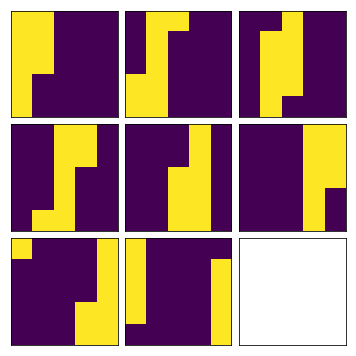

Execution time: at iteration 0 is 2.160578727722168 seconds


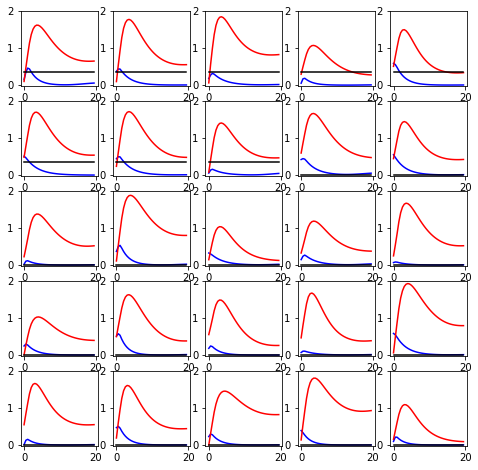

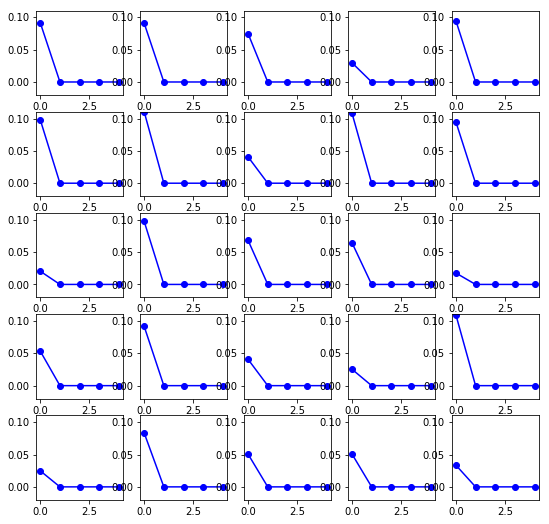

Presentation 1
Execution time: at iteration 1 is 1.8033325672149658 seconds


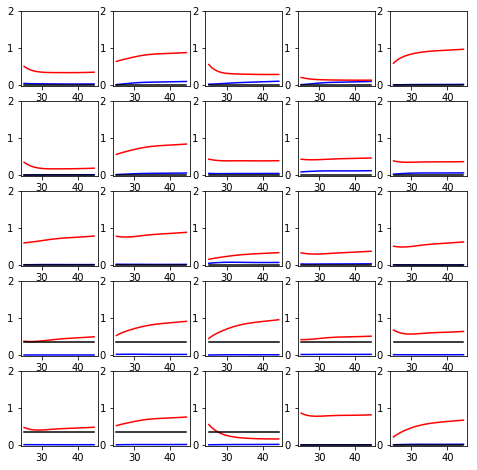

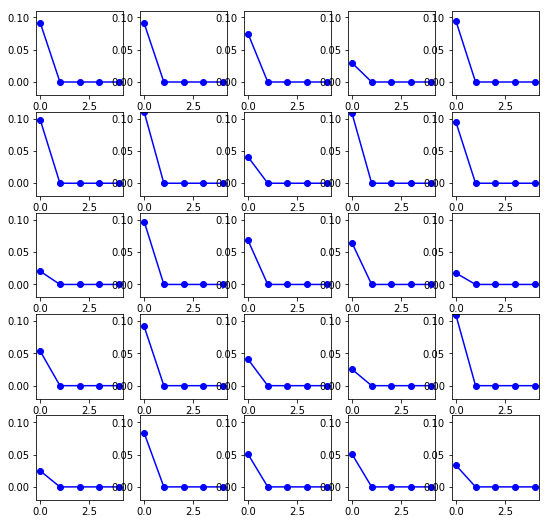

Presentation 2
Execution time: at iteration 2 is 1.8401360511779785 seconds


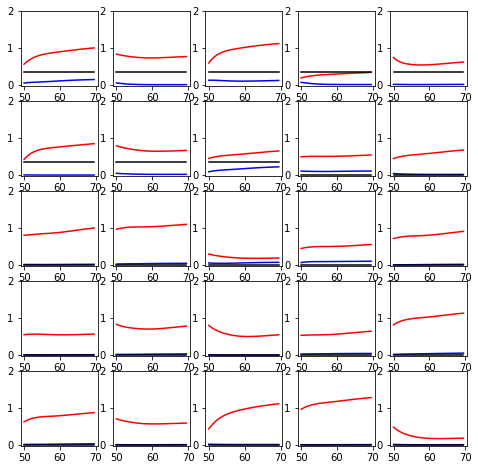

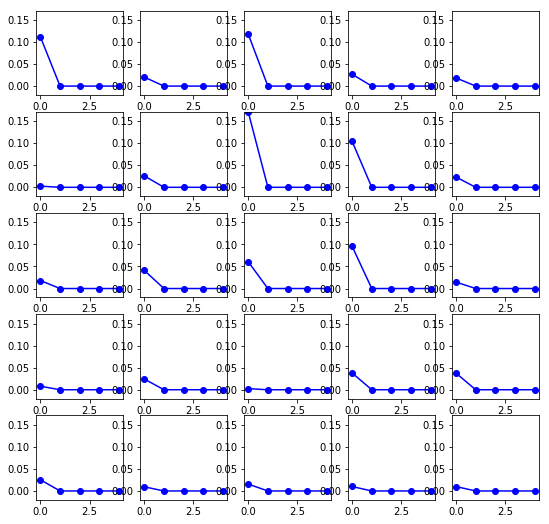

Presentation 3


In [3]:
sel = selection()
sel.net_params['min_delay'] = 0.5
sel.build('snake')
sel.display_inputs()
n_pres = 3
n_disp = 2
sel.run(n_pres, n_disp)

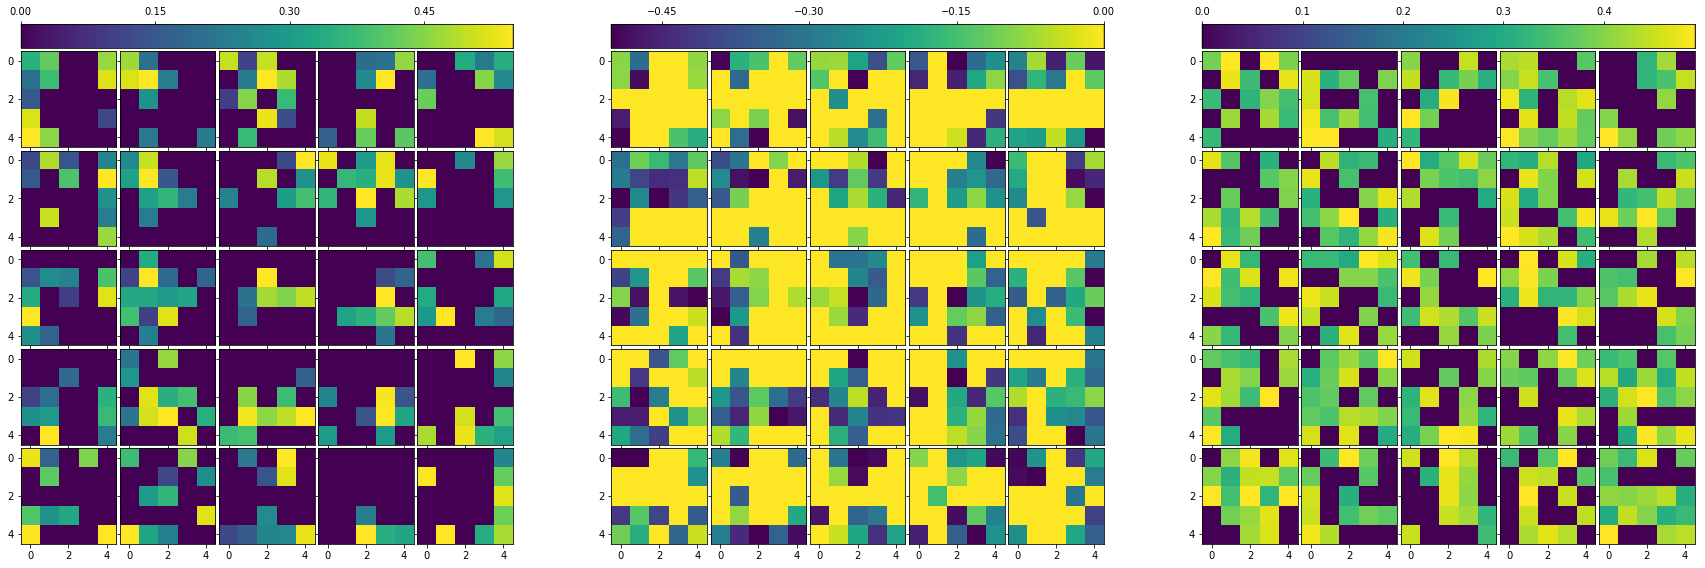

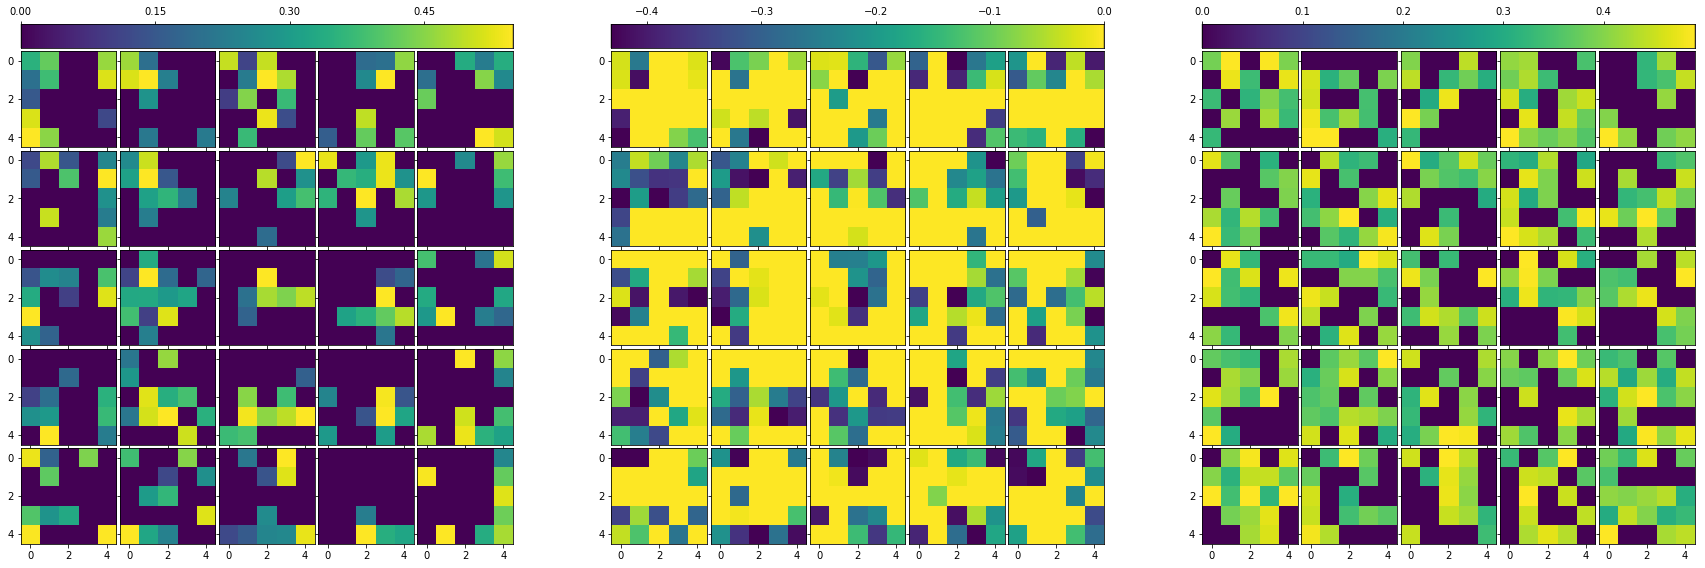

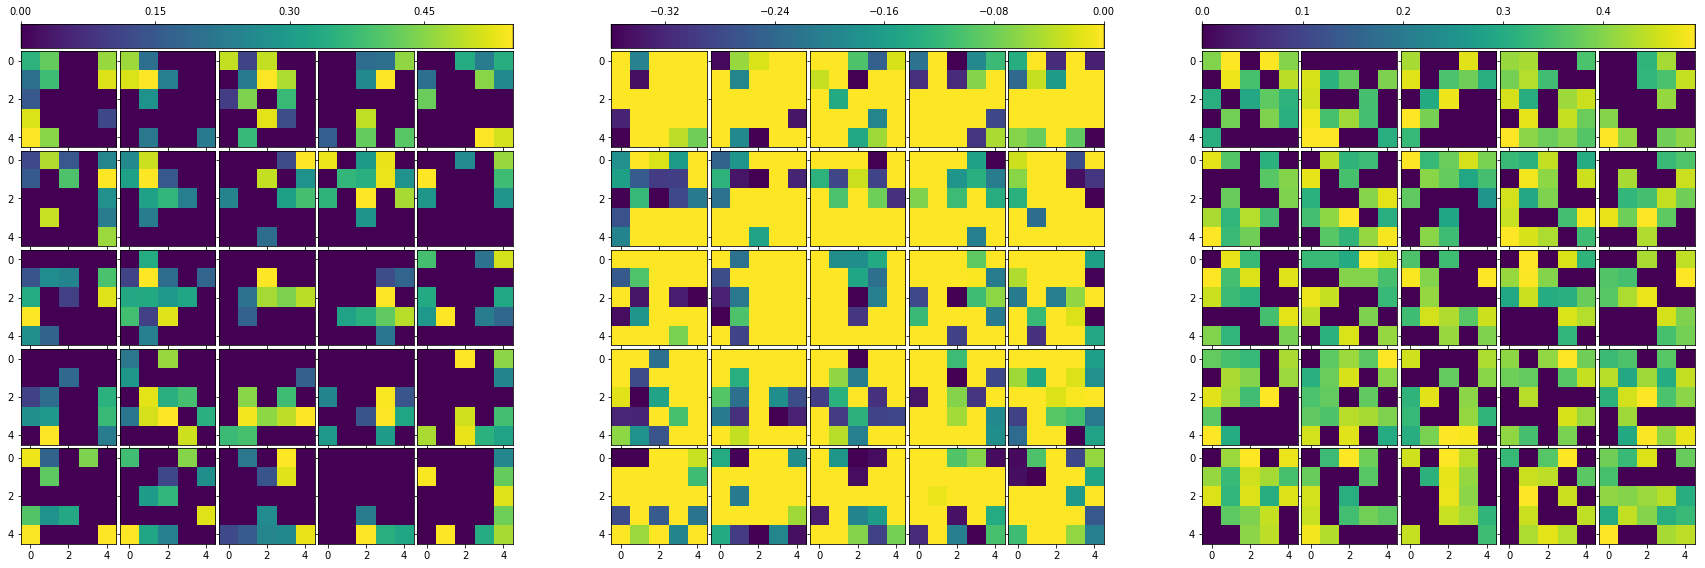

Excitatory squared sums:	[2.0266453008119996, 2.0271430774163064, 2.0288125040984353]
Inhibitory sums:	[-2.6601605738425316, -1.9988025828344296, -1.6217885520375943]
External input sums: 	[5.7033637173814409, 5.7060648678076822, 5.9376044554782563]


In [4]:
sel.view_weight_grid()

<IPython.core.display.Javascript object>


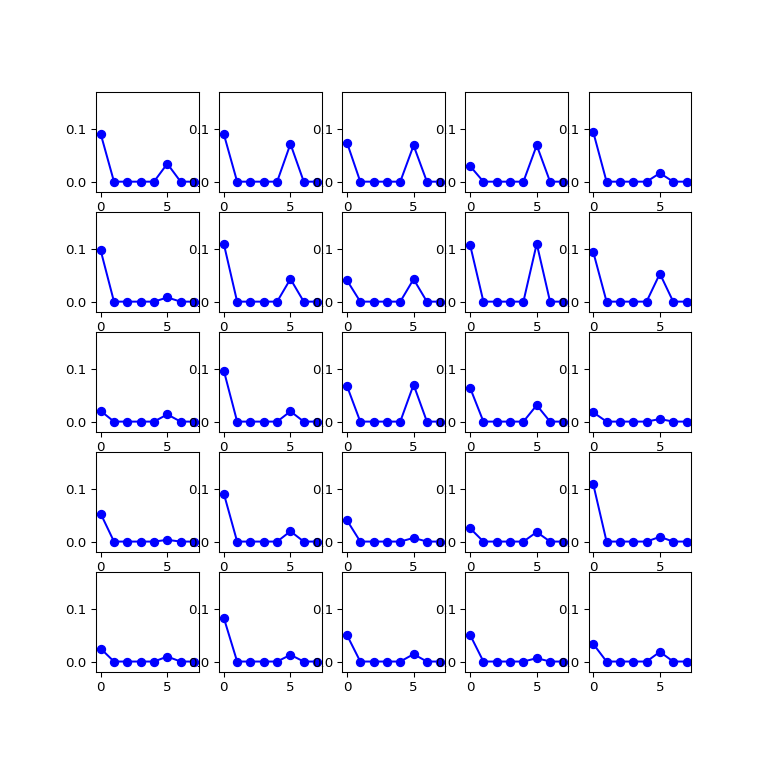

In [6]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook
ani = sel.animate_responses(50)
plt.show()

The point of these simulations is to find whether the E-I network with the type of plasticity from Moldakarinov06 is suited for becoming a network where each unit selects a particular subset of the descending inputs.

Due to the topological arrangement of the connections, it is reasonable to assume that spatially structured inputs, such as the "progressive lines" will have patterns that target some units slightly more than others. The point is for the network to pick on those slight preferences and to enhance them using the lateral connections as exta constraints.

In the case of the progressive lines we can: 
* find a 'center' for each pattern, as the average of the coordinates for each unit that is on when the pattern is present. That's the 'centers' vector obtained above.
* for each excitatory unit, measure its average activity level for each pattern. 
* plot what is the correlation between the distance to a pattern VS the activity level when the pattern is presented.
  This can be done in first vs last iterations.

This figure shows that units become very selective to particular patterns, and the number of units devoted to each pattern is evenly distributed. It is not quite how I imagined it, but it couldn't be better.